In [127]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import yfinance as yf

from datetime import datetime
import itertools as it
from math import sqrt
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

import wrangle

In [128]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

## First I will acquire and prep the data for modeling

In [129]:
# use a function to pull in data
nem, nem_hr, holo, holo_hr = wrangle.get_crypto_data()
nem.shape, nem_hr.shape, holo.shape, holo_hr.shape

((1535, 6), (1091, 6), (1363, 6), (1091, 6))

In [130]:
# use a function to split daily data for NEM
nem_train, nem_validate, nem_test = wrangle.split_time_series_data(nem)

# use a function to split hourly data for NEM
nem_hr_train, nem_hr_validate, nem_hr_test = wrangle.split_time_series_data(nem_hr)

# use a function to split daily data for HOLO
holo_train, holo_validate, holo_test = wrangle.split_time_series_data(holo)

# use a function to split hourly data for HOLO
holo_hr_train, holo_hr_validate, holo_hr_test = wrangle.split_time_series_data(holo_hr)

In [131]:
# drop columns that will not be used in the prediction
# NEM daily data
nem_train, nem_validate, nem_test = pd.DataFrame(nem_train['Close']),\
                                    pd.DataFrame(nem_validate['Close']),\
                                    pd.DataFrame(nem_test['Close'])
# NEM hourly data
nem_hr_train, nem_hr_validate, nem_hr_test = pd.DataFrame(nem_hr_train['Close']),\
                                             pd.DataFrame(nem_hr_validate['Close']),\
                                             pd.DataFrame(nem_hr_test['Close'])
# HOLO daily data
holo_train, holo_validate, holo_test = pd.DataFrame(holo_train['Close']),\
                                       pd.DataFrame(holo_validate['Close']),\
                                       pd.DataFrame(holo_test['Close'])
# HOLO hourly data
holo_hr_train, holo_hr_validate, holo_hr_test = pd.DataFrame(holo_hr_train['Close']),\
                                                pd.DataFrame(holo_hr_validate['Close']),\
                                                pd.DataFrame(holo_hr_test['Close'])

In [132]:
nem_train.shape, nem_validate.shape, nem_test.shape, nem_hr_train.shape, nem_hr_validate.shape, nem_hr_test.shape, holo_train.shape, holo_validate.shape, holo_test.shape, holo_hr_train.shape, holo_hr_validate.shape, holo_hr_test.shape

((767, 1),
 (460, 1),
 (308, 1),
 (545, 1),
 (327, 1),
 (219, 1),
 (681, 1),
 (408, 1),
 (274, 1),
 (545, 1),
 (327, 1),
 (219, 1))

In [133]:
nem_validate.head()

,Close
Date,
2019-12-16,0.033951
2019-12-17,0.031043
2019-12-18,0.033601
2019-12-19,0.032319
2019-12-20,0.032923


## Next I will create functions to use during modeling

In [134]:
# compute rmse to evaluate model
def evaluate(validate_set, yhat):
    rmse = round(sqrt(mean_squared_error(validate_set['Close'], yhat['Close'])), 5)
    return rmse


# plot original and predicted values
def plot_and_eval(train_set, validate_set, yhat, model):
    plt.plot(train_set['Close'], label = 'Train', linewidth = 1)
    plt.plot(validate_set['Close'], label = 'Validate', linewidth = 1)
    plt.plot(yhat['Close'], label = 'Prediction', linewidth = 1)
    plt.title('Actual Closing Price vs ' + model)
    plt.legend()
    plt.xticks(rotation=45)
    rmse = evaluate(validate_set, yhat)
    print(f'{model} RMSE: {rmse}')
    plt.show()
    

# create df object to append metrics to
eval_df = pd.DataFrame(columns=['model', 'rmse'])

# calculate evaluation metrics and append to dataframe
def append_eval_df(eval_df, train_set, validate_set, yhat, model):
    rmse = evaluate(validate_set, yhat)
    d = pd.DataFrame({'model': [model], 'rmse': [rmse]})
    eval_df = eval_df.append(d, ignore_index = True)
    return eval_df

### Establish a baseline model
* I am going to start by modeling only on NEM daily data and with additional time will go into hourly data as well as HOLO data

<AxesSubplot:xlabel='Date'>

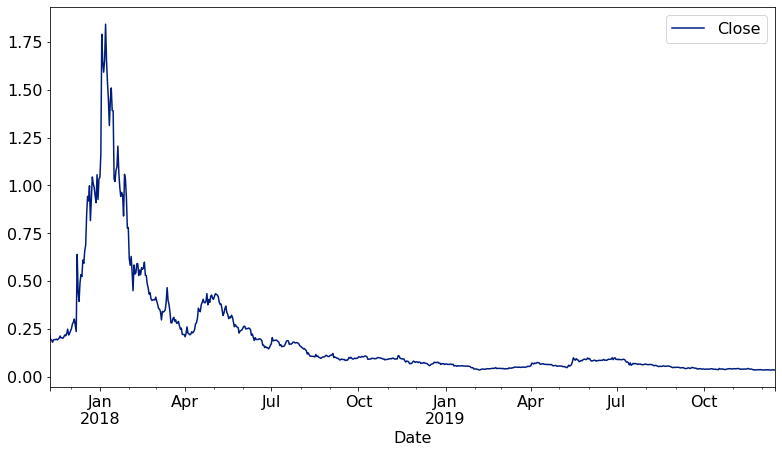

In [135]:
# plot data
nem_train.plot()

**For NEM, I am going to use the simple average for the train data. I will use RMSE as the evaluation metric for my models**

In [136]:
# predict using mean of train close data
close = nem_train.Close.mean()

yhat = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

In [137]:
round(nem_train.Close.mean(), 5)

0.2

Baseline Prediction RMSE: 0.1587


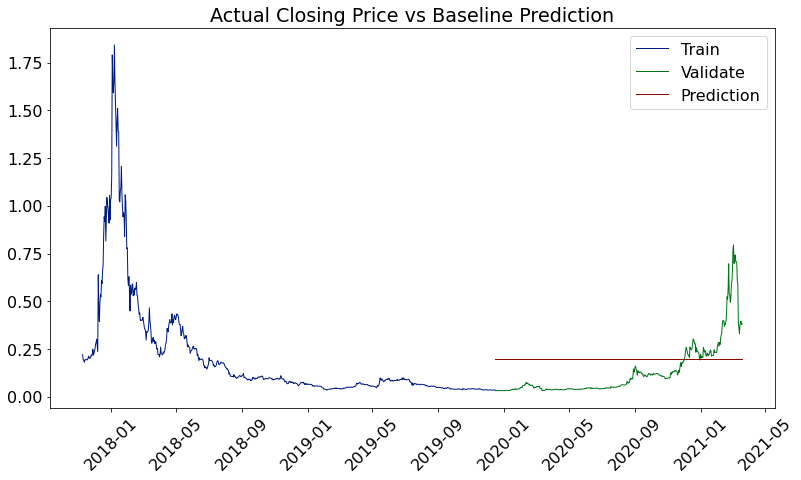

In [138]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, 'Baseline Prediction')

In [139]:
nem_train.columns

Index(['Close'], dtype='object')

In [140]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'baseline')
eval_df

,model,rmse
0,baseline,0.1587


### For any model to be of value, it must beat the baseline RMSE

### Make predictions using moving average and evaluate

In [141]:
# First try 30 day rolling average and use the most recent/last 30 day period value to predict forward. 
close = round(nem_train.Close.rolling(30).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

30day_rolling_avg RMSE: 0.17151


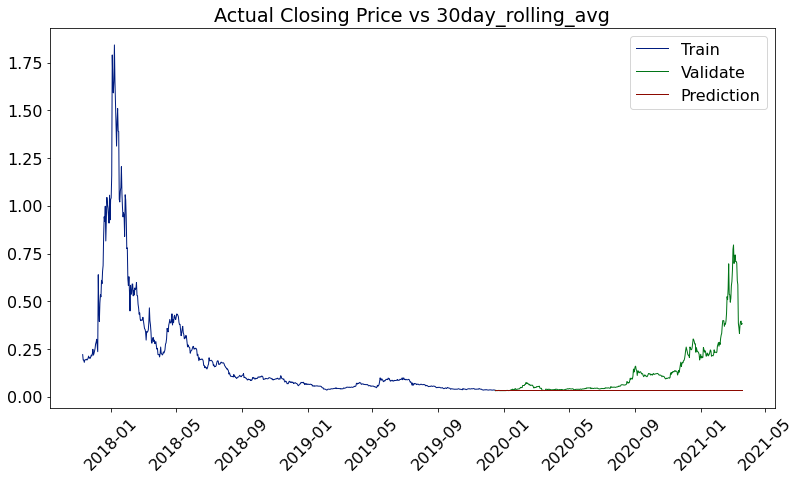

In [142]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, '30day_rolling_avg')

In [143]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, '30day_rolling_avg')
eval_df

,model,rmse
0,baseline,0.15870
1,30day_rolling_avg,0.17151


In [144]:
# Next try 7 day rolling average and use the most recent/last 7 day period value to predict forward. 
close = round(nem_train.Close.rolling(7).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

7day_rolling_avg RMSE: 0.17233


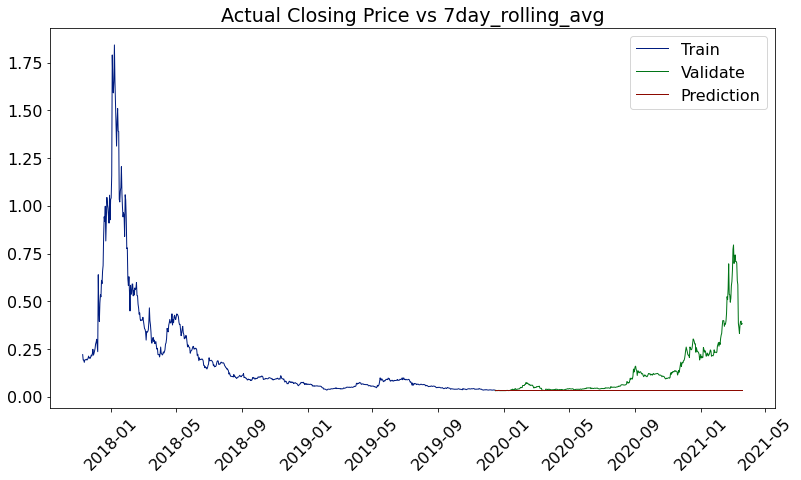

In [145]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, '7day_rolling_avg')

In [146]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, '7day_rolling_avg')
eval_df

,model,rmse
0,baseline,0.15870
1,30day_rolling_avg,0.17151
2,7day_rolling_avg,0.17233


In [147]:
# Next try 365 day rolling average and use the most recent/last 365 day period value to predict forward. 
close = round(nem_train.Close.rolling(365).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

365day_rolling_avg RMSE: 0.16129


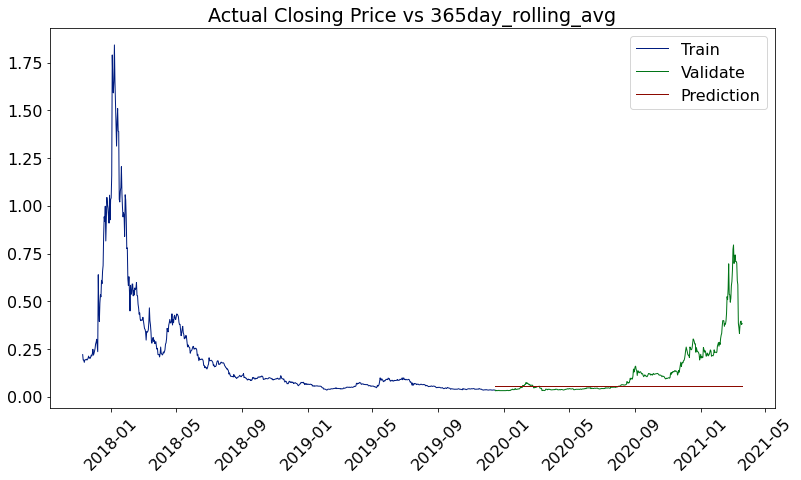

In [148]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, '365day_rolling_avg')

In [149]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, '365day_rolling_avg')
eval_df

,model,rmse
0,baseline,0.15870
1,30day_rolling_avg,0.17151
2,7day_rolling_avg,0.17233
3,365day_rolling_avg,0.16129


### Make predictions using Holt's Linear Trend and evaluate

In [150]:
# create the model
close = Holt(nem_train.Close, exponential = False)
# fit the model
close = close.fit(smoothing_level = .2, smoothing_slope = .9, optimized = True)

# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = nem_validate.index[0], end = nem_validate.index[-1]), 5), columns=['Close'])

Holt's Linear Trend RMSE: 0.13713


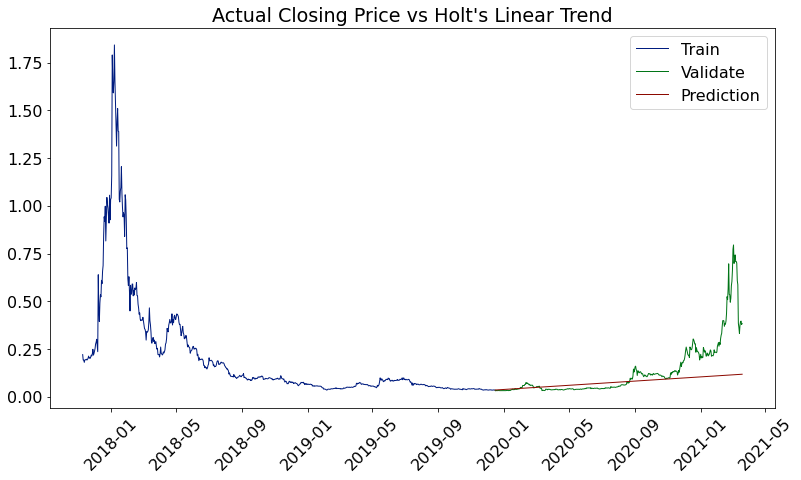

In [151]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, 'Holt\'s Linear Trend')

**I tried many different values for smoothing_level and smoothing_slope from 0 to 1 and .2 and .9, respectively, produced the best RMSE**

In [152]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'holts_linear_trend')
eval_df

,model,rmse
0,baseline,0.15870
1,30day_rolling_avg,0.17151
2,7day_rolling_avg,0.17233
3,365day_rolling_avg,0.16129
4,holts_linear_trend,0.13713


### Make predictions using ARIMA and evaluate

In [153]:
# use iteration to find the best hyperparameter values
p = d = q = range(0, 2)
pdq = list(it.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [154]:
# this code takes a while to run. 
# for param in pdq:
#     for param_model in model_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(nem_train,
#                                             order=param,
#                                             seasonal_order=param_model,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_model, results.aic))
#         except:
#             continue

**Using the code above I discovered order=(0,0,0) to produce the lowest AIC, however, the autocorrelation chart created during explore shows slight correlation with 5 lag periods so I tried order=(5,0,0) as well and it produced a lower RMSE.**

In [155]:
# create the model
close = ARIMA(nem_train.Close, order=(5,0,0))
# fit the model
close = close.fit()
# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = nem_validate.index[0], end = nem_validate.index[-1]), 5), columns=['Close'])

ARIMA RMSE: 0.13104


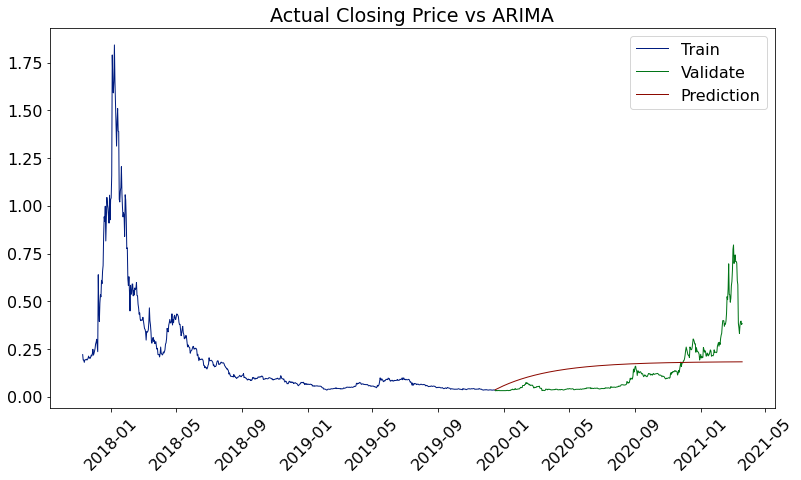

In [156]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, 'ARIMA')

In [157]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'arima')
eval_df

,model,rmse
0,baseline,0.15870
1,30day_rolling_avg,0.17151
2,7day_rolling_avg,0.17233
3,365day_rolling_avg,0.16129
4,holts_linear_trend,0.13713
5,arima,0.13104


### Make predictions using FB Prophet and evaluate

In [158]:
# adjust columns for model
df = nem_train.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
predict_df = nem_validate.reset_index().drop(columns='Close').rename(columns={'Date':'ds'})

In [159]:
predict_df.head()

,ds
0,2019-12-16
1,2019-12-17
2,2019-12-18
3,2019-12-19
4,2019-12-20


In [160]:
# adjust columns for model
df = nem_train.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
predict_df = nem_validate.reset_index().drop(columns='Close').rename(columns={'Date':'ds'})

# create the model
close = Prophet()
# fit the model
close = close.fit(df)
# use the model to predict
yhat = close.predict(predict_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


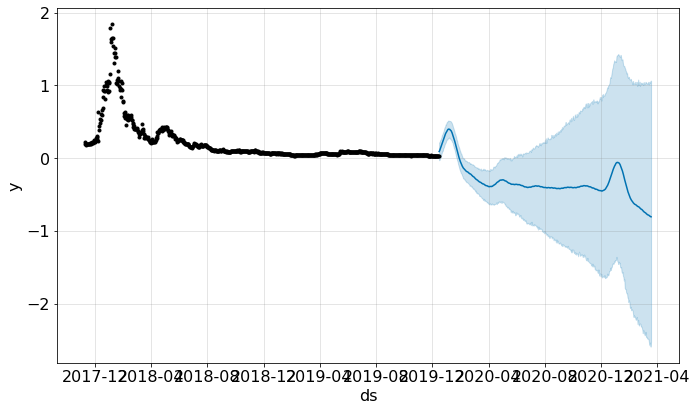

In [161]:
# plot predictions
fig = close.plot(yhat)

In [162]:
# creat interactive chart
from prophet.plot import plot_plotly
plot_plotly(close, yhat)

In [163]:
yhat = pd.DataFrame(yhat.rename(columns={'ds':'Date', 'yhat':'Close'}).set_index('Date').sort_index().loc[:,'Close'])
yhat.head()

,Close
Date,
2019-12-16,0.091451
2019-12-17,0.102939
2019-12-18,0.120096
2019-12-19,0.134061
2019-12-20,0.153910


Prophet RMSE: 0.56229


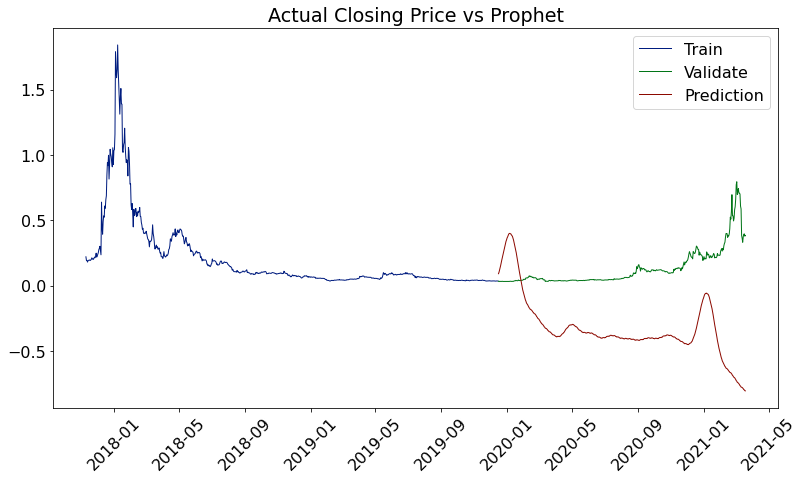

In [164]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, 'Prophet')

In [165]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'prophet')
eval_df

,model,rmse
0,baseline,0.15870
1,30day_rolling_avg,0.17151
2,7day_rolling_avg,0.17233
3,365day_rolling_avg,0.16129
4,holts_linear_trend,0.13713
5,arima,0.13104
6,prophet,0.56229


In [37]:
# # plot data
# holo_train.plot()

In [38]:
# # predict using mean for all train data
# close = holo_train.Close.mean()

# yhat_df = pd.DataFrame({'Close': [close]}, index = holo_validate.index)

In [39]:
# # plot actual vs predicted
# plot_and_eval(holo_train, holo_validate, 'Close')

In [40]:
# # append metrics to evaluate dataframe
# for col in holo_train.columns:
#     eval_df = append_eval_df(model_type='holo_baseline_simple_average', validate_set=holo_validate,
#                              target_var=col)
# eval_df